# David Silver's Easy21 Assignment

Rules of the game:

1. Game is played with infinite deck of cards $=>$ cards are sampled with replacement

2. Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).

3. No picture cards!

4. At the start of the game both the player and the dealer draw one black card (fully observed)

5. Each turn the player may either stick or hit:
     
       If the player hits then she draws another card from the deck
     
       If the player sticks she receives no further cards


6. The values of the player’s cards are added (black cards) or subtracted (red cards)

7. If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)

8. If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

# Implementation of Easy21 enviroment

In [4]:
import numpy as np

In [5]:
'''

Create a deck to draw cards from. 

Each deck is 2/3 black cards, 1/3 red. Black card have +ve value, red cards -ve value. 

Deck has a pick_card() method that selects a card and returns its value.

'''


class Deck:
    def pick_card(self):
        number = np.random.randint(1, 11)
        colour = np.random.uniform(0, 1, 1)
        
        if colour > float(2/3):
            colour = -1 # -1 corrresponds to red.
        else:
            colour = 1 # 1 corredponds to black. This allows you to do value = colour*number 

        value = number*colour

        return value

In [6]:
'''

The state object tracks the score of both the dealer and the agent.

Additionally it has a terminal attribute, when this is set to True the game has ended. 

This occurs either because the agent is bust, the dealer is bust or after the agent 'Sticks' the dealer also 

'Sticks'.

'''

class State:
    def __init__(self, dealer_score=0, agent_score=0, terminal=False):
        self.dealer_score = dealer_score
        self.agent_score = agent_score
        self.terminal = terminal
        
'''

The Action class allows us to call either Action.hit or Action.stick. 

Associating with binary values allows us to write them into Boolean expressions later. 

Note 1 evalutes to True, 0 evaluates to False

'''
        
class Action:
    stick = 1
    hit = 0

In [7]:
#The dealer follows the policy of sticking on 17+ 

class Dealer():
    def policy(self, state):
        "Given a current state s, execute the policy as described in the rules."
        if state.dealer_score >= 17:
            return Action.stick
        else:
            return Action.hit

In [8]:
class Enviroment():
    def __init__(self):
        
        
        '''
        The enviroment is built for the Agent to exist within. 
        
        It contains a deck and a dealer.
        
        '''
        
        self.dealer = Dealer()
        self.deck = Deck()
    
    def check_bust(self, player_score): #To check if players are bust.  
        return player_score < 1 or player_score > 21
    
    def reward(self, state): #Compare players scores, hand out rewards.
        if state.agent_score > state.dealer_score:
            return 1
        elif state.agent_score < state.dealer_score:
            return -1
        else:
            return 0
        
    def draw_card(self): #Draw card from deck.
        return self.deck.pick_card()
        
    def dealer_play(self, state):
        
        '''
        
        A complete dealer turn. Starts when the agent sticks and ends when the dealers policy dicates, or
        the dealer goes bust.
        
        It returns an updated state; the agent_score is the same but the dealer_score is updated to a new value. 
        
        '''
        
        action = None #initalise a null action for first time through loop
        while not state.terminal and action != Action.stick:
            
            action = self.dealer.policy(state) #update actiona acording to dealer policy
            if action == Action.hit:
                state.dealer_score += self.draw_card()
            state.terminal = self.check_bust(state.dealer_score) #check if the dealer is bust!
        
        return state
    
    
    def inital_state(self): 
        return State(dealer_score=np.random.randint(1, 11), agent_score=np.random.randint(1, 11))
        
    def step(self, state, action):
        
        '''
        
        As described by Silver in the notes. 
        
        Given a state (dealer_score, agent_score) and an action (stick or hit) 'step' returns the next state 
        and some reward due to the dealer following his policy, getting a score and then comparing with the 
        agent. 
        
        '''
        
        import copy
        
        r = 0 #initalise reward to zero
        next_state = copy.copy(state) #initalise next state as current state
        
        if action == Action.stick: #after agent sticks, dealer plays! 
            next_state = self.dealer_play(state)
            
            if next_state.terminal: #if the dealer goes bust (terminal = True), give agent reward!
                r+=1
            
            else: #otherwise compare agent and dealer scores
                next_state.terminal = True
                r = self.reward(next_state)
                
        else: #if agent does not stick, they hit and so draw a card! 
            next_state.agent_score += self.draw_card() 
            next_state.terminal = self.check_bust(next_state.agent_score)   #check if agent is bust! 
            
            if next_state.terminal:
                r -= 1
            
            
        return r, next_state

In [11]:
enviroment = Enviroment()
enviroment.inital_state()

# MC Control

In [89]:
class MC_ControlAgent:
    def __init__(self, enviroment, N_0=100):
        
        self.env = enviroment #The agent exists in some enviroment, defined from the Enviroment class
        
        self.N_0 = N_0 #This attribute is fixed
        
        self.Q = np.zeros(shape=(21, 10, 2)) #Matrix of state-action values
        self.N = np.zeros(shape=(21, 10, 2)) #Matrix records how often a state has been visited + action executed
    
    def get_ep(self, state): 
        return self.N_0/(self.N_0 + sum(self.N[state.agent_score-1, state.dealer_score-1, :]))
    
    def get_alpha(self, state, action):
        return 1/self.N[state.agent_score-1, state.dealer_score-1, action]
    
    def find_optimal_action(self, state): #Given a state s, find the optimal action. 
                                          #That is the one with the larger Q(s, a) value! 
        return  np.argmax(self.Q[state.agent_score-1][state.dealer_score-1])
    
    def pick_random_action(self): #Exploration - choose a random action! 
        return Action.hit if np.random.random() < 0.5 else Action.stick

    def epsilon_greedy(self, state): #Choose action by implementing an epsilon-greedy policy.
        
        if np.random.random() < self.get_ep(state):
            action = self.pick_random_action()
        else:
            action = self.find_optimal_action(state)

        return action
    
    def generate_episode(self):
        
        '''
        
        Play and record one episode of the game. 
        
        Each player (agent and dealer) are initalised w self.env.inital_state(). 
        
        The agent plays in accordance with the policy; 
        
        If the agents sticks, the dealer plays his turn untill the episode terminates and the reward is calcualted. 
        
        Otherwise the epsiode is terminated if the agent goes bust. The reward (-1) is the assigned and the 
        
        '''
        
        #Define an inital state
        
        game = self.env.inital_state()
        store_episode = []
        
        while not game.terminal: #i.e. whilst the episode is NOT terminal, do some stuff...
            
            #choose an action, from epsilon-greedy policy
            
            a = self.epsilon_greedy(game)
            
            #perform the chosen action using the step funtion
            
            import copy
            r, new_game_state = self.env.step(copy.copy(game), a)
            
            #step() returns a new state and reward! store this state and update the oringal game object
            
            store_episode.append((game, a, r))
            game = new_game_state

        return store_episode
    
    def control_updates(self, episode):
        
        '''
        
        Pass function an episode i.e. the states reached, the actions taken from each state, and the reward
        achieved at each step. 
        
        Unwrap all of this information i.e. the 'state' part needs to be unpacked from a memory address.
        
        Find the return! I.e. the reward associated with the final state (all other rewards will be zero)
        
        Then update Q(s,a) towards Q(s,a)* with update rule.... Q+= alpha*(return - Q) for each Q(s, a) state
        visited within the episode.
        
        Update the N matrix, recording the states which are visited and the actions taken.
        
        '''
        
        returns = []
        for s, a, r in episode:
            #Find total return, same for all Q(s,a) in episode
            returns.append(r)
            G_t = sum(returns)
            
            self.N[s.agent_score-1, s.dealer_score-1, a] += 1
            self.Q[s.agent_score-1, s.dealer_score-1, a] += self.get_alpha(s, a) * (G_t - self.Q[s.agent_score-1, s.dealer_score-1, a])
            
        return self.Q, self.N
    
    def MC_train(self, n_episodes):
        for episode in range(n_episodes):
            self.control_updates(self.generate_episode())
            
            if episode%1000000 ==0:
                print('Working...')
        
        return self.Q

In [90]:
agent = MC_ControlAgent(enviroment)
import timeit
start_time = timeit.default_timer()
Q_star = agent.MC_train(5000000)
elapsed = timeit.default_timer() - start_time
#Q_star = agent.MC_train(10000000)

Working...
Working...
Working...
Working...
Working...


In [91]:
Q_star_test = np.copy(Q_star)
Q_star_test = np.amax(Q_star_test, 2)
Q_star_test.shape

(21, 10)

In [92]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def plot_value_function(value_function, title='Value Function', generate_gif=False, train_steps=None):
    """

    """
    fig = plt.figure(figsize=(20, 5))
    #fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax1 = fig.add_subplot(122)
    
    V = value_function
    
    #if generate_gif:
        #print('gif will be saved as %s' % title)
    
    def plot_frame(ax):
        
        min_x = 1
        max_x = 21
        min_y = 0
        max_y = 10


        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)
        
        X, Y = np.meshgrid(x_range, y_range)

        # get value function for X and Y values
        def get_stat_val(x, y):
            return V[x, y]
        Z = get_stat_val(X, Y)

        # creates a surface to be ploted
        
        
        
        #fig,ax=plt.subplots(1,1)
        #cp = ax1.contourf(X+1, Y+1, Z)
        fig.colorbar(ax1.contourf(X+1, Y+1, Z)) # Add a colorbar to a plot
        ax1.set_title(r'Value Function $Q^{*}(s, a)$', fontsize=16, pad=10)
        ax1.set_xlabel('Agent Score', fontsize=16, labelpad=10)
        ax1.set_ylabel('Dealer Showing', fontsize=16, labelpad=10)
        
        
        ax.set_title(r'Value Function $Q^{*}(s, a)$', fontsize=16, pad=20)
        ax.set_xlabel('Dealer Showing', fontsize=16, labelpad=20)
        ax.set_ylabel('Player Sum', fontsize=16, labelpad=20)
        
        ax.tick_params(axis='x', which='major', labelsize=18)
        ax.tick_params(axis='y', which='major', labelsize=20)
        ax.tick_params(axis='z', which='major', labelsize=18)
        ax1.tick_params(axis='x', which='major', labelsize=18)
        ax1.tick_params(axis='y', which='major', labelsize=14)
        #ax.set_zlabel('Value', fontsize=16)
        #ax.set_ylim(min_x, max_x)
        
        return ax.plot_surface(Y+1, X+1, Z, rstride=1, cstride=1, cmap=cm.viridis, 
                               linewidth=0.2, antialiased=False), ax1.contourf(X+1, Y+1, Z)
    
    plot_frame(ax)
    ax.set_xlim(1, 10)
    plt.show()
    #fig.savefig('Desktop/Easy21_MC')
    
    
    
    '''
    def animate(frame):
        # clear the plot and create a new surface
        ax.clear()
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train a couple of times
    
        
        if generate_gif:
            i = agent.iterations
            # cool math to increase number of steps as we go
            if train_steps is None:
                step_size = int(min(max(1, agent.iterations), 2 ** 16))
            else:
                step_size = train_steps

            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
        
        #else:
        plt.title(title)

        fig.canvas.draw()
        return surf
    
    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # requires gif writer
    
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    
    #else:
    plt.show()  
    '''

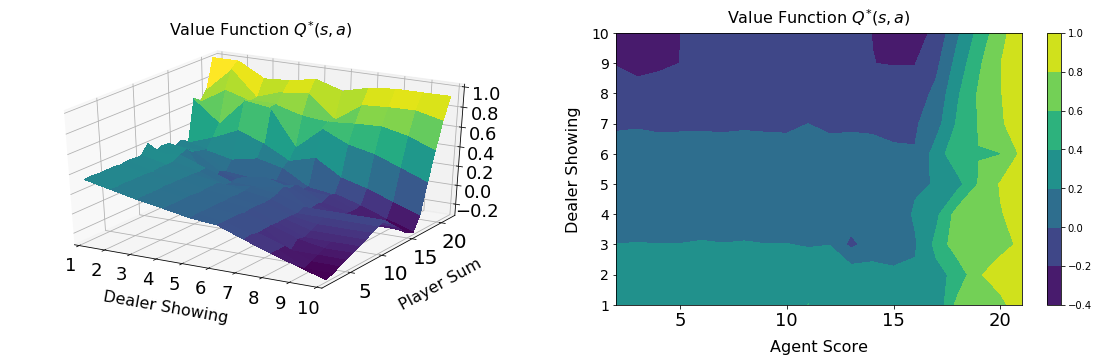

In [93]:
plot_value_function(Q_star_test)

# TD Learning

In [87]:
class TD_Agent: #An agent that learns via Temporal-Difference learning, specifically the SARSA algorithm
    def __init__(self, enviroment, N_0=100, lambda_=1):
    
        self.env = enviroment

        self.N_0 = N_0 #This attribute is fixed
        self.lambda_ = lambda_ #lambda_ used rather than lambda as lambda is a protected word in python, lambda functions

        self.Q = np.zeros(shape=(21, 10, 2)) #Matrix of state-action values
        self.N = np.zeros(shape=(21, 10, 2)) #Matrix records how often a state has been visited + action executed
        self.E = np.zeros(shape=(21, 10, 2)) #Matrix record eligibility trace assocaited with each state


        '''
        Note - lots of these attributes are all the same for the MC agent. Perhaps create a parent agent class they can 
        inheret these properteies from? 

        Also the code creating the (21, 10, 2) matrix is repeated each time, could define a general matrix and
        call it each  time it is needed?

        All of the enviroment code can be reused in this section. 

        '''

    def get_q(self, state, action):
        return self.Q[state.agent_score-1, state.dealer_score-1, action]

    def get_ep(self, state): 
        return self.N_0/(self.N_0 + sum(self.N[state.agent_score-1, state.dealer_score-1, :]))

    def get_alpha(self, state, action):
        return 1/self.N[state.agent_score-1, state.dealer_score-1, action]

    def find_optimal_action(self, state): #Given a state s, find the optimal action. 
                                              #That is the one with the larger Q(s, a) value! 
        return np.argmax(self.Q[state.agent_score-1][state.dealer_score-1])

    def pick_random_action(self): #Exploration - choose a random action! 
        return Action.hit if np.random.random() < 0.5 else Action.stick


    def epsilon_greedy(self, state): #Choose action by implementing an epsilon-greedy policy.
        if np.random.random() < self.get_ep(state):
            action = self.pick_random_action()
        else:
            action = self.find_optimal_action(state)
            
        #add to N here, unlike in MC control
        self.N[state.agent_score-1, state.dealer_score-1, action] +=1 
        return action


        '''

        Instead of generating the episdoes and passing it to a control function, as in the MC case, here I think 
        it is better to run a single training function that does 

        this way we don't have to pass the TD-Error delta between functions, its scope is local and doesn't have to
        exist outside of this single function.

        Code is longer but probably nicer to read, maybe faster? 

        '''

    def SARSA_train(self, n_episodes):
        for episode in range(n_episodes):
            self.E = np.zeros(shape=(21, 10, 2))
            
            game = self.env.inital_state()
            a = self.epsilon_greedy(game)
            a_prime = a

            while not game.terminal:
                import copy
                r, new_game_state = self.env.step(copy.copy(game), a)
                q = self.get_q(game, a)
                
                if not new_game_state.terminal:
                    a_prime = self.epsilon_greedy(new_game_state)
                    q_prime = self.get_q(new_game_state, a_prime)
                    delta = r + q_prime - q

                else:
                    delta = r - q

                #Update eligibility trace, E, and state-action value function, Q
                
                self.E[game.agent_score-1, game.dealer_score-1, a]+=1
                alpha = self.get_alpha(game, a)
                q_update = alpha*delta*self.E
                self.Q += q_update
                self.E *= self.lambda_

                game = new_game_state
                a = a_prime
                #update state and actions

            if episode %1000000 == 0:
                print("Working...")

        return self.Q

Working...
Working...
Working...
Working...
Working...
Working...
Working...
Working...
Working...
Working...


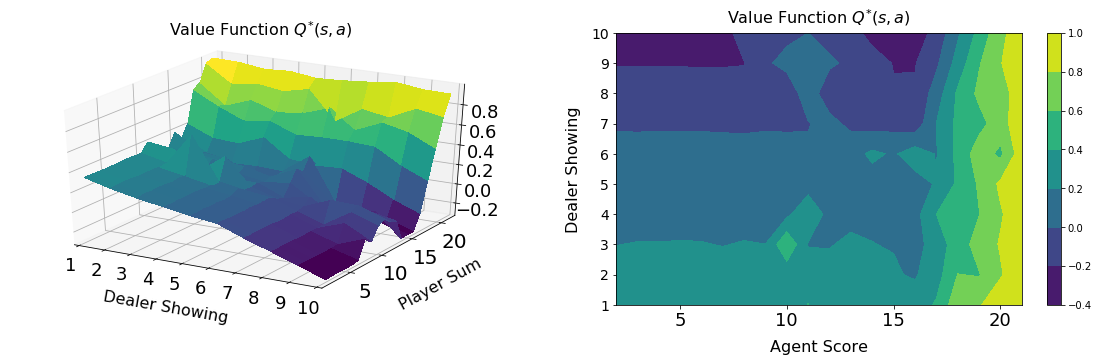

In [88]:
sarsa_agent = TD_Agent(enviroment)
Q_sarsa = sarsa_agent.SARSA_train(10000000)

Q_sarsa_plot = np.copy(Q_sarsa)
Q_sarsa_plot = np.amax(Q_sarsa, 2)
plot_value_function(Q_sarsa_plot)